### A jupyter notebook for analysing mixed sanger data files

#### Exploring the use of python to extract secondary sequences from mixed ab1 files

In [24]:
from Bio import SeqIO
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [25]:
%matplotlib notebook

#### Set you abi folder path
<br>
Make sure you file are named appropreately, name-R and name-F

In [26]:
ab1Folder = 'ab1/'

In [27]:
ab1List = []
ab1PairDict = {}
keyList = []
traceSetDict = {}
for trace in os.listdir(ab1Folder):
    if ".ab1" in trace:
        trace = trace
        ab1List.append(trace)
        keyList.append(trace.replace("R", "").replace("F", "").replace(".ab1", ""))
        traceSetDict[trace] = trace.replace("R", "").replace("F", "").replace(".ab1", "")

keyList = list(set(keyList)) 

for key in keyList:
    pair = []
    for ab1 in ab1List:
        if key == ab1.replace("R", "").replace("F", "").replace(".ab1", ""):
            pair.append(ab1)
    ab1PairDict[key] = pair


print(ab1PairDict)

{'203-4_diluted': ['203-4_dilutedF.ab1', '203-4_dilutedR.ab1'], '203-4': ['203-4F.ab1', '203-4R.ab1']}


We now have a python dictionary with a key and a list of trace files.

### Run tracy to call bases

https://github.com/gear-genomics/tracy

tracy can also be used to decompose sequences, trying on a desktop PC did not work, requires more than 16 GB of ram for full chromosome 9.  It does work with just the gene of interest.

In [28]:
for trace in ab1List:
    tracy_cmd = "./tracy basecall -f tsv -o output/{} ab1/{}".format(trace.replace(".ab1", ".tsv"), trace)
    print(tracy_cmd)
    os.popen(tracy_cmd)
    
    
    

./tracy basecall -f tsv -o output/203-4F.tsv ab1/203-4F.ab1
./tracy basecall -f tsv -o output/203-4R.tsv ab1/203-4R.ab1
./tracy basecall -f tsv -o output/203-4_dilutedF.tsv ab1/203-4_dilutedF.ab1
./tracy basecall -f tsv -o output/203-4_dilutedR.tsv ab1/203-4_dilutedR.ab1


Import our results into a dataframe

In [29]:
baseDf = pd.DataFrame()
for key in ab1PairDict:
    print(key)
    for ab1 in ab1PairDict[key]:
        print(ab1)
        
        tmpDf = pd.read_csv('output/{}.tsv'.format(ab1.replace(".ab1", "")), delimiter= "\t")
        tmpDf['key'] = key
        tmpDf['trace'] = ab1
        baseDf = baseDf.append(pd.DataFrame(data = tmpDf), ignore_index=True)

203-4_diluted
203-4_dilutedF.ab1
203-4_dilutedR.ab1
203-4
203-4F.ab1
203-4R.ab1


In [7]:
baseDf.head()

,pos,peakA,peakC,peakG,peakT,basenum,primary,secondary,consensus,qual,trim,key,trace
0,1,6,20,2,0,NaN,NaN,NaN,NaN,NaN,NaN,203-4_diluted,203-4_dilutedF.ab1
1,2,6,20,2,0,NaN,NaN,NaN,NaN,NaN,NaN,203-4_diluted,203-4_dilutedF.ab1
2,3,6,20,2,0,NaN,NaN,NaN,NaN,NaN,NaN,203-4_diluted,203-4_dilutedF.ab1
3,4,6,20,2,0,NaN,NaN,NaN,NaN,NaN,NaN,203-4_diluted,203-4_dilutedF.ab1
4,5,6,20,2,0,NaN,NaN,NaN,NaN,NaN,NaN,203-4_diluted,203-4_dilutedF.ab1


Remove all positions where basenum is NA

In [30]:
baseDf = baseDf[np.isfinite(baseDf['basenum'])]
baseDf = baseDf.loc[baseDf['qual'] > 9]

In [31]:
baseDf.head()

,pos,peakA,peakC,peakG,peakT,basenum,primary,secondary,consensus,qual,trim,key,trace
269,270,85,1,84,0,18.0,C,C,C,11.0,Y,203-4_diluted,203-4_dilutedF.ab1
288,289,76,0,161,28,20.0,T,T,T,11.0,Y,203-4_diluted,203-4_dilutedF.ab1
297,298,80,0,179,25,21.0,G,A,N,10.0,Y,203-4_diluted,203-4_dilutedF.ab1
335,336,73,1,227,24,24.0,G,G,G,23.0,Y,203-4_diluted,203-4_dilutedF.ab1
346,347,40,17,90,146,25.0,T,T,T,27.0,Y,203-4_diluted,203-4_dilutedF.ab1


Plot the quality values to get an idea

<IPython.core.display.Javascript object>


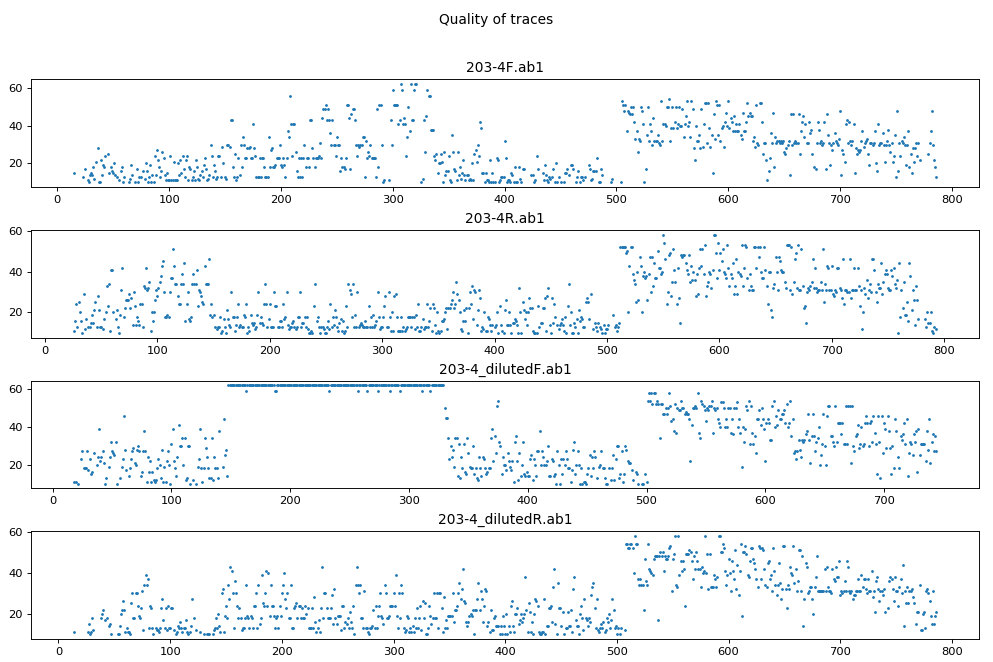

In [32]:
fig=plt.figure(figsize=(12,8),dpi= 80, facecolor='w', edgecolor='k')

for trace in ab1List:

    plt.subplot(len(ab1List), 1, ab1List.index(trace)+1)
    plt.tight_layout(pad=0.4, h_pad=1)
    plotDf = baseDf.loc[baseDf['trace'] == trace]
    plt.scatter(x = plotDf['basenum'], y = plotDf['qual'], s = 2)
    plt.title(trace)
plt.suptitle('Quality of traces')
fig.subplots_adjust(top=0.88)
plt.show()

Explore the sanger file base on the plot above

### Extract the primary and secondary peaks

In [33]:
primaryFasta = open("output/primary.fasta", "w")
for trace in ab1List:
    primaryDf = baseDf.loc[baseDf['trace'] == trace]
    primary = primaryDf['primary'].tolist()
    primary = ''.join(primary)
    print(">{}".format(trace))
    print(primary)
    primaryFasta.write(">{}".format(trace))
    primaryFasta.write('\n')
    primaryFasta.write(primary)
    primaryFasta.write('\n')
primaryFasta.close()

>203-4F.ab1
GGCGGACGGCGGTTCTCCAGGTTTCACCGGTCGTGCGACGGAGGTGTACGAGGGCGTGTGGAAGAGATACGGCCTGACGGTGGCCGTGAAGACCTTGAAGGAGGACACCTTGGGGTGGAAGAGTTCTTGAAAGAAGCTGCTGTCATGAAAGATATCAAACACCCTAACCTGGTGCAGCTCCTTGGGGTCTGCACCCGGGAGCCCCCGTTCTATATCATCACTGAGTTCATGACCTACGGGAACCTCCGGGACTACGGGAGTGCAACCGGCAGGAGGTGAACGGGTGCTGCTGTACATGGACTCTCACATGTCGTCACCCATGGGGTACCTGGAGAAGAAAAACTTCACCACAGAGATTGTGGTGCCGAAACGACCGGACCACGTGGAAACTCTGATTTGATGAGCAGCATTACAGGGACTAGTGGAGCCAAGTTCCCCATCAAATGGACTGCACCCGAGAGCCTGGCCTACAACAAGTTCTCCATCAAGTCCGACGTCTGGGCATTTGGAGTATTGCTTTGGGAAATTGCTACCTATGGCATGTCCCCGTACCTGGCACTTGACCTGTCCTAAGTGTATGAGCTGCTAGAGAAAACTACTGCATGAAGCGTCTAGTAAGGCTGCCCAGAGAAAGTCTATGTACTCATGCGAGCATGTTGGCAGTGGTATCCCTCTGACCGGGTCCTCCTAAGTCTCC
>203-4R.ab1
TAGCTGGATGCACAAGGAGGGCCGTCAGAGGGATCCACTGCCAACATGCTCGCATGAGTTCATAGACCTTCTCTGGGCAGCCTTCTGGGCGCTCCATGCGGTAGTCCTTCTCTAGCAGCTCAACGCCTGGGACAGGTGAATTCCCGGGTAAGGGGACATGGCATAGGTGGCAATTTCCNAAAGGAATTCTCCGAATGACCAGAAGTCGGATTGATGGAGAACTTGTTGTAGGGCAGGCTCTCGGGTGGAGGCCATTTGATGGGGAACTTGGCTCCAGC

In [34]:
secondaryFasta = open("output/secondary.fasta", "w")
for trace in ab1List:
    secondaryDf = baseDf.loc[baseDf['trace'] == trace]
    secondary = secondaryDf['secondary'].tolist()
    secondary = ''.join(secondary)
    print(">{}".format(trace))
    print(secondary)
    secondaryFasta.write(">{}".format(trace))
    secondaryFasta.write('\n')
    secondaryFasta.write(secondary)
    secondaryFasta.write('\n')
secondaryFasta.close()

>203-4F.ab1
CCGMGTCTMCTAMTCACCGTGGCACACGAWGCAGCCCACWTGGAGTTTCCAGGAGAAATTTAAGAATTTGATRAGGATGGAATCTGCCAATTGKTTCTGGGACGTTTCTATTYGTTGGAAGATTTTTTGAATGATTCTTCACTCYTTTTGTAGTTKAAAGAGCCGKGCCAGGATCAGCGGCTTGTGGTCTGCKCGKGGAAGCCCCCGTTCTATGTCATTACTGAGTTCAGGATCTACGGGAAGGTGGTGGACTAGGGGAGTGCAACCGGTGGGAGGTGAACGGGTGCTGCTAGAGAAGGYCAACCGGATCGAGCGCGCAGAAGACTGCCCAGAGAAGGTCTATGAACCATGCGAGCACTTTCGCACGGAATGTAGGCCCTTTTCTGTATGAAAGCCTTGGTATGCTTTATRACAGTWACAAGTGGAGCCAAGTTCCCCATCAAATGGACTGTATCCGAGAGCCTGGCCTACAACAAGTTCTCCATCAAGTCCAACGTCCGGGCATTTGGAGTATTGCTTTGGGAAATTGCTACCTATGGCATGTCCCCGTATCTGGCACTTGACTTGACCRAAGTGTATGAGCTGCTAGAGAAAACTACTGCATGYAGCGGCTAGCAAGGCTGCCCGGAGAAAGTCTATGTATTCATGCGAGCATGTTGGCAGTGGTATCCCTTTGACCGGGGCCCCCGAAGTCGAC
>203-4R.ab1
TAGATAAATGCTGAGTTATGGCTTTCAGAGGGATTTGCTGCTAATATGTTCCCTTGAGAGCATAATGGTGCGTTGGTGAGTTTTCTGGATTTTCCATGCGATAGTACTGCTGTAGCAGCATCCGACRTTCWCCTCYTCYCGGWTGYAYTCCYTYWAKYTGCCSAGGWSMTWYYCGTAGNTCAWYTACACAGTATATGYATAGACCGKGGGTTCCTGGTGAYCTRCCSMAGGACCTGGACCARGYTAGYGTTKTTTRTCTCTTTCATGACTGCTGCTTC

### blast analysis

In [35]:
!blastn -query output/primary.fasta -db ref/ABL -outfmt 6 -max_target_seqs 1 -out output/primary.blast
!blastn -query output/secondary.fasta -db ref/ABL -outfmt 6 -max_target_seqs 1 -out output/secondary.blast

#### Read in the blast results

In [36]:
priDf = pd.read_csv('output/primary.blast', delimiter="\t", header=None,  usecols = [0,2,6,7,8,9])
priDf.head(n = -1)

,0,2,6,7,8,9
0,203-4F.ab1,92.420,40,371,762,1104
1,203-4F.ab1,93.284,423,689,1191,1456
2,203-4R.ab1,91.801,10,738,1460,718
3,203-4_dilutedF.ab1,96.517,112,705,833,1435


In [37]:
secDf = pd.read_csv('output/secondary.blast', delimiter="\t", header=None, usecols = [0, 2,6,7,8,9])
secDf.head(n = -1)

,0,2,6,7,8,9
0,203-4F.ab1,90.000,423,681,1191,1449
1,203-4R.ab1,94.403,467,734,989,722
2,203-4_dilutedF.ab1,93.522,461,705,1189,1435
3,203-4_dilutedF.ab1,98.500,112,311,833,1032
4,203-4_dilutedF.ab1,90.226,296,428,1350,1482


#### Plot the results

<IPython.core.display.Javascript object>


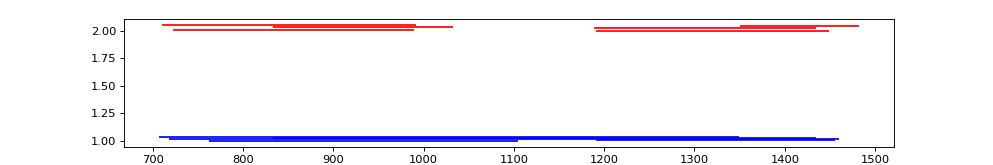

In [38]:
fig=plt.figure(figsize=(12,2),dpi= 80, facecolor='w', edgecolor='k')
yPri = 1
ySec = 2
for index, row in priDf.iterrows():
    #print(row[6], row[7])
    plt.hlines(xmin=row[8], xmax=row[9], y=yPri, colors='blue')
    yPri = yPri +0.01
for index, row in secDf.iterrows():
    #print(row[6], row[7])
    plt.hlines(xmin=row[8], xmax=row[9], y=ySec, colors='red')
    ySec = ySec +0.01
plt.show()

The figure above shows the blast results for the primary (blue) and secondary (red).

In [39]:
setList = []
for index, _ in priDf.iterrows():
    trace = priDf[0][index]
    key = traceSetDict[trace]
    setList.append(key)
priDf['key'] = setList

In [40]:
setList = []
for index, _ in secDf.iterrows():
    trace = secDf[0][index]
    key = traceSetDict[trace]
    setList.append(key)
secDf['key'] = setList

In [41]:
priDf.head(n = 100)

,0,2,6,7,8,9,key
0,203-4F.ab1,92.420,40,371,762,1104,203-4
1,203-4F.ab1,93.284,423,689,1191,1456,203-4
2,203-4R.ab1,91.801,10,738,1460,718,203-4
3,203-4_dilutedF.ab1,96.517,112,705,833,1435,203-4_diluted
4,203-4_dilutedR.ab1,92.846,94,729,1349,707,203-4_diluted


In [42]:
secDf.head(n = 100)


,0,2,6,7,8,9,key
0,203-4F.ab1,90.000,423,681,1191,1449,203-4
1,203-4R.ab1,94.403,467,734,989,722,203-4
2,203-4_dilutedF.ab1,93.522,461,705,1189,1435,203-4_diluted
3,203-4_dilutedF.ab1,98.500,112,311,833,1032,203-4_diluted
4,203-4_dilutedF.ab1,90.226,296,428,1350,1482,203-4_diluted
5,203-4_dilutedR.ab1,91.166,447,726,992,710,203-4_diluted


<IPython.core.display.Javascript object>


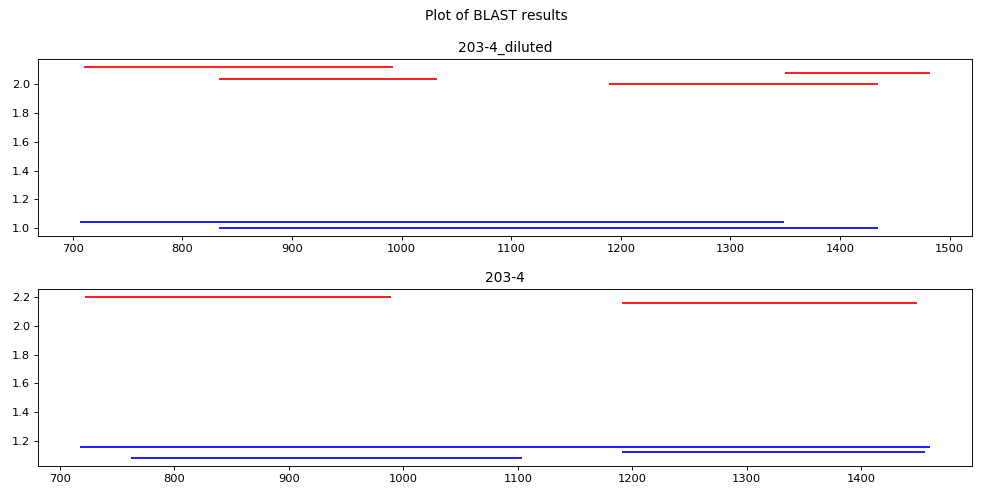

In [43]:
fig=plt.figure(figsize=(12,6),dpi= 80, facecolor='w', edgecolor='k')
yPri = 1
ySec = 2

for key in keyList:
    plt.subplot(len(keyList), 1, keyList.index(key)+1)
    plt.tight_layout(pad=1, h_pad=3)
    plotPriDf = priDf.loc[priDf['key'] == key]
    plotSecDf = secDf.loc[secDf['key'] == key]
    
    for index, row in plotPriDf.iterrows():
        #print(row[6], row[7])
        plt.hlines(xmin=row[8], xmax=row[9], y=yPri, colors='blue')
        yPri = yPri +0.04
    
    for index, row in plotSecDf.iterrows():
        #print(row[6], row[7])
        plt.hlines(xmin=row[8], xmax=row[9], y=ySec, colors='red')
        ySec = ySec +0.04
    plt.title(key)
    
plt.suptitle('Plot of BLAST results')
fig.subplots_adjust(top=0.88)
plt.show()

In [44]:
!blastn -query output/primary.fasta -db ref/ABL -outfmt 2 


BLASTN 2.5.1+


Reference: Zheng Zhang, Scott Schwartz, Lukas Wagner, and Webb
Miller (2000), "A greedy algorithm for aligning DNA sequences", J
Comput Biol 2000; 7(1-2):203-14.



Database: ABL
           1 sequences; 3,393 total letters



Query= 203-4F.ab1

Length=697
                                                                      Score     E
Sequences producing significant alignments:                          (Bits)  Value

  NM_005157.5:193-3585 Homo sapiens ABL proto-oncogene 1, non-rec...  479     1e-138



Query_1  40    GGAGGTGTACGAGGGCGTGTGGAAGAGATACGGCCTGACGGTGGCCGTGAAGACCTTGAA  99
0        762   GGAGGTGTACGAGGGCGTGTGGAAGAAATACAGCCTGACGGTGGCCGTGAAGACCTTGAA  821

Query_1  100   GGAGGACACCTTGGGGTGGAAGAGTTCTTGAAAGAAGCTGCTGTCATGAAAGATATCAAA  159
0        822   GGAGGACACCATGGGGTGGAAGAGTTCTTGAAAGAAGCTGCAGTCATGAAAGAGATCAAA  882
                             \                                             
                             |                                            

In [45]:
!blastn -query output/secondary.fasta -db ref/ABL -outfmt 2

BLASTN 2.5.1+


Reference: Zheng Zhang, Scott Schwartz, Lukas Wagner, and Webb
Miller (2000), "A greedy algorithm for aligning DNA sequences", J
Comput Biol 2000; 7(1-2):203-14.



Database: ABL
           1 sequences; 3,393 total letters



Query= 203-4F.ab1

Length=697
                                                                      Score     E
Sequences producing significant alignments:                          (Bits)  Value

  NM_005157.5:193-3585 Homo sapiens ABL proto-oncogene 1, non-rec...  335     3e-95



Query_1  423   TGGAGCCAAGTTCCCCATCAAATGGACTGTATCCGAGAGCCTGGCCTACAACAAGTTCTC  482
0        1191  TGGAGCCAAGTTCCCCATCAAATGGACTGCACCCGAGAGCCTGGCCTACAACAAGTTCTC  1250

Query_1  483   CATCAAGTCCAACGTCCGGGCATTTGGAGTATTGCTTTGGGAAATTGCTACCTATGGCAT  542
0        1251  CATCAAGTCCGACGTCTGGGCATTTGGAGTATTGCTTTGGGAAATTGCTACCTATGGCAT  1310

Query_1  543   GTCCCCGTATCTGGCACTTGACTTGACCRAAGTGTATGAGCTGCTAGAGAAAACTACTGC  602
0        1311  GTCCCCTTACCCGGGAATTGACCTGTCCCAGGTGTATGAGCTGCTAGAGAA

### Use tracy to decompose the ab1 files against the refernce

In [46]:
!mkdir output/tracy

#### A python loop to handle tracy's decompose function for you

In [53]:
for ab1 in ab1List:
    tracy_decompose_cmd = "./tracy decompose -p 0.2 -g ref/ABL_ref.fasta -f align -o output/tracy/{} ab1/{}".format(ab1.replace(".ab1", ""), ab1) 
    print(tracy_decompose_cmd)
    os.popen(tracy_decompose_cmd)

./tracy decompose -p 0.2 -g ref/ABL_ref.fasta -f align -o output/tracy/203-4F ab1/203-4F.ab1
./tracy decompose -p 0.2 -g ref/ABL_ref.fasta -f align -o output/tracy/203-4R ab1/203-4R.ab1
./tracy decompose -p 0.2 -g ref/ABL_ref.fasta -f align -o output/tracy/203-4_dilutedF ab1/203-4_dilutedF.ab1
./tracy decompose -p 0.2 -g ref/ABL_ref.fasta -f align -o output/tracy/203-4_dilutedR ab1/203-4_dilutedR.ab1
